In [13]:
#https://www.kaggle.com/datasets/carrie1/ecommerce-data

**Import Libraries**

In [14]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


**Loading Dataset**

In [15]:
# Load the dataset
df = pd.read_csv('data.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Check for missing values**

In [16]:
# Check for null values
print("Checking for null values:")
print(df.isnull().sum())

Checking for null values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [17]:
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

/tmp/ipython-input-17-2613567002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)
/tmp/ipython-input-17-2613567002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [18]:
# Check for null values
print("Checking for null values:")
print(df.isnull().sum())

Checking for null values:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


**Encode Categorical Features (Country)**

In [19]:
# Step 4: Feature Engineering
# Create OrderCount per Customer
customer_order_counts = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
customer_order_counts.columns = ['CustomerID', 'OrderCount']

df = df.merge(customer_order_counts, on='CustomerID', how='left')

# New Target: Will the customer place more than 1 order? (Repeat Buyer)
df['RepeatBuyer'] = (df['OrderCount'] > 1).astype(int)

# Extract time features
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# One-hot encode country
country_encoded = pd.get_dummies(df['Country'], drop_first=True)

# Final dataset: remove target leakage columns (InvoiceNo, StockCode, Description, InvoiceDate)
df_model = pd.concat([
    df[['Quantity', 'UnitPrice', 'CustomerID', 'DayOfWeek', 'Hour', 'RepeatBuyer']],
    country_encoded
], axis=1)

**Train-Test Split**

In [20]:
# Step 5: Prepare features and target
X = df_model.drop('RepeatBuyer', axis=1)
y = df_model['RepeatBuyer']

In [21]:
# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Train the Decision Tree Classifier**

In [22]:
# Step 7: Train Decision Tree
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=42)

**Evaluate the Model**

In [23]:
# Step 8: Evaluation
y_pred = clf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[  416  5347]
 [   14 75589]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.07      0.13      5763
           1       0.93      1.00      0.97     75603

    accuracy                           0.93     81366
   macro avg       0.95      0.54      0.55     81366
weighted avg       0.94      0.93      0.91     81366

Accuracy Score: 0.9341125285745889


In [24]:
# Cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5)
print("Cross-validated scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-validated scores: [0.92871715 0.92794288 0.92892609 0.92693508 0.92930621]
Mean CV Accuracy: 0.9283654826492951


**Visualize the Decision Tree**

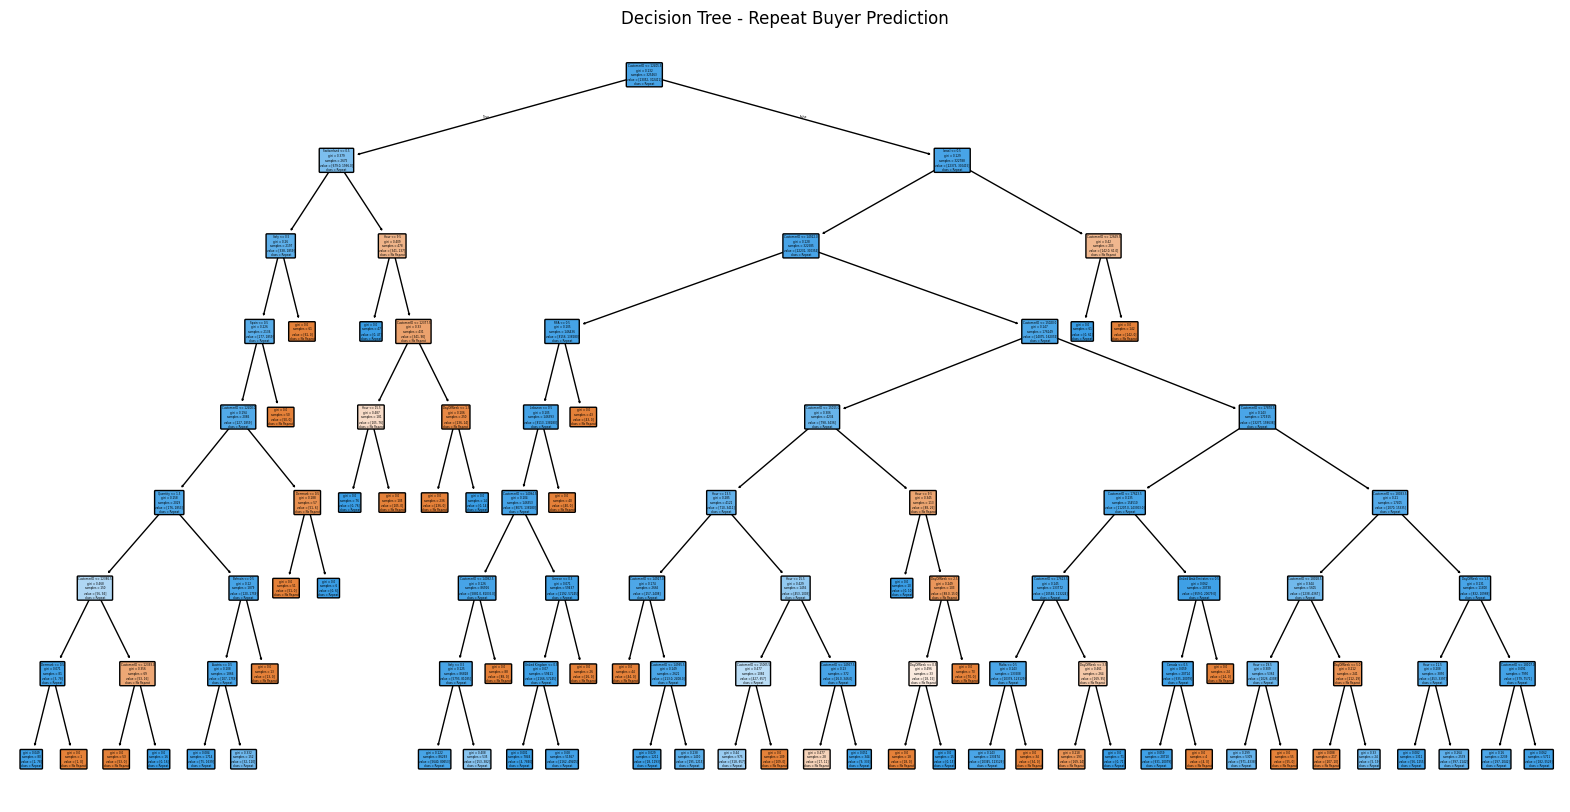

In [25]:
# Step 10: Visualize tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=["No Repeat", "Repeat"], filled=True, rounded=True)
plt.title("Decision Tree - Repeat Buyer Prediction")
plt.show()

**Feature Importance**

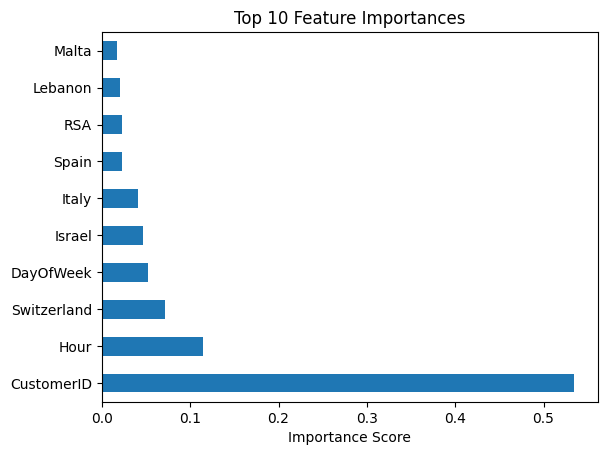

In [26]:
# Step 9: Visualize feature importance
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()